In [1]:
import matplotlib.pyplot as plt

In [2]:
"""
Contains the logic from chapter 20 on multiprocessing and vectorization.
"""
import sys
import time
import datetime as dt

import multiprocessing as mp

import numpy as np
import pandas as pd


# Snippet 20.5 (page 306), the lin_parts function
def lin_parts(num_atoms, num_threads):
    """
    Advances in Financial Machine Learning, Snippet 20.5, page 306.
    The lin_parts function
    The simplest way to form molecules is to partition a list of atoms in subsets of equal size,
    where the number of subsets is the minimum between the number of processors and the number
    of atoms. For N subsets we need to find the N+1 indices that enclose the partitions.
    This logic is demonstrated in Snippet 20.5.
    This function partitions a list of atoms in subsets (molecules) of equal size.
    An atom is a set of indivisible set of tasks.
    :param num_atoms: (int) Number of atoms
    :param num_threads: (int) Number of processors
    :return: (np.array) Partition of atoms
    """
    # Partition of atoms with a single loop
    parts = np.linspace(0, num_atoms, min(num_threads, num_atoms) + 1)
    parts = np.ceil(parts).astype(int)
    return parts


# Snippet 20.6 (page 308), The nested_parts function
def nested_parts(num_atoms, num_threads, upper_triangle=False):
    """
    Advances in Financial Machine Learning, Snippet 20.6, page 308.
    The nested_parts function
    This function enables parallelization of nested loops.
    :param num_atoms: (int) Number of atoms
    :param num_threads: (int) Number of processors
    :param upper_triangle: (bool) Flag to order atoms as an upper triangular matrix (including the main diagonal)
    :return: (np.array) Partition of atoms
    """
    # Partition of atoms with an inner loop
    parts = [0]
    num_threads_ = min(num_threads, num_atoms)

    for _ in range(num_threads_):
        part = 1 + 4 * (parts[-1] ** 2 + parts[-1] + num_atoms * (num_atoms + 1.0) / num_threads_)
        part = (-1 + part ** 0.5) / 2.0
        parts.append(part)

    parts = np.round(parts).astype(int)

    if upper_triangle:  # The first rows are heaviest
        parts = np.cumsum(np.diff(parts)[::-1])
        parts = np.append(np.array([0]), parts)

    return parts


# Snippet 20.7 (page 310), The mpPandasObj, used at various points in the book
def mp_pandas_obj(func, pd_obj, num_threads=24, mp_batches=1, lin_mols=True, **kargs):
    """
    Advances in Financial Machine Learning, Snippet 20.7, page 310.
    The mpPandasObj, used at various points in the book
    Parallelize jobs, return a dataframe or series.
    Example: df1=mp_pandas_obj(func,('molecule',df0.index),24,**kwds)
    First, atoms are grouped into molecules, using linParts (equal number of atoms per molecule)
    or nestedParts (atoms distributed in a lower-triangular structure). When mpBatches is greater
    than 1, there will be more molecules than cores. Suppose that we divide a task into 10 molecules,
    where molecule 1 takes twice as long as the rest. If we run this process in 10 cores, 9 of the
    cores will be idle half of the runtime, waiting for the first core to process molecule 1.
    Alternatively, we could set mpBatches=10 so as to divide that task in 100 molecules. In doing so,
    every core will receive equal workload, even though the first 10 molecules take as much time as the
    next 20 molecules. In this example, the run with mpBatches=10 will take half of the time consumed by
    mpBatches=1.
    Second, we form a list of jobs. A job is a dictionary containing all the information needed to process
    a molecule, that is, the callback function, its keyword arguments, and the subset of atoms that form
    the molecule.
    Third, we will process the jobs sequentially if numThreads==1 (see Snippet 20.8), and in parallel
    otherwise (see Section 20.5.2). The reason that we want the option to run jobs sequentially is for
    debugging purposes. It is not easy to catch a bug when programs are run in multiple processors.
    Once the code is debugged, we will want to use numThreads>1.
    Fourth, we stitch together the output from every molecule into a single list, series, or dataframe.
    :param func: (function) A callback function, which will be executed in parallel
    :param pd_obj: (tuple) Element 0: The name of the argument used to pass molecules to the callback function
                    Element 1: A list of indivisible tasks (atoms), which will be grouped into molecules
    :param num_threads: (int) The number of threads that will be used in parallel (one processor per thread)
    :param mp_batches: (int) Number of parallel batches (jobs per core)
    :param lin_mols: (bool) Tells if the method should use linear or nested partitioning
    :param kargs: (var args) Keyword arguments needed by func
    :return: (pd.DataFrame) of results
    """

    if lin_mols:
        parts = lin_parts(len(pd_obj[1]), num_threads * mp_batches)
    else:
        parts = nested_parts(len(pd_obj[1]), num_threads * mp_batches)

    jobs = []
    for i in range(1, len(parts)):
        job = {pd_obj[0]: pd_obj[1][parts[i - 1]:parts[i]], 'func': func}
        job.update(kargs)
        jobs.append(job)

    if num_threads == 1:
        out = process_jobs_(jobs)
    else:
        out = process_jobs(jobs, num_threads=num_threads)

    if isinstance(out[0], pd.DataFrame):
        df0 = pd.DataFrame()
    elif isinstance(out[0], pd.Series):
        df0 = pd.Series()
    else:
        return out

    for i in out:
        df0 = df0.append(i)

    df0 = df0.sort_index()
    return df0


# Snippet 20.8, pg 311, Single thread execution, for debugging
def process_jobs_(jobs):
    """
    Advances in Financial Machine Learning, Snippet 20.8, page 311.
    Single thread execution, for debugging
    Run jobs sequentially, for debugging
    :param jobs: (list) Jobs (molecules)
    :return: (list) Results of jobs
    """
    out = []
    for job in jobs:
        out_ = expand_call(job)
        out.append(out_)

    return out


# Snippet 20.10 Passing the job (molecule) to the callback function
def expand_call(kargs):
    """
    Advances in Financial Machine Learning, Snippet 20.10.
    Passing the job (molecule) to the callback function
    Expand the arguments of a callback function, kargs['func']
    :param kargs: Job (molecule)
    :return: Result of a job
    """
    func = kargs['func']
    del kargs['func']
    out = func(**kargs)
    return out


# Snippet 20.9.1, pg 312, Example of Asynchronous call to pythons multiprocessing library
def report_progress(job_num, num_jobs, time0, task):
    """
    Advances in Financial Machine Learning, Snippet 20.9.1, pg 312.
    Example of Asynchronous call to pythons multiprocessing library
    :param job_num: (int) Number of current job
    :param num_jobs: (int) Total number of jobs
    :param time0: (time) Start time
    :param task: (str) Task description
    :return: (None)
    """
    # Report progress as asynch jobs are completed
    msg = [float(job_num) / num_jobs, (time.time() - time0) / 60.0]
    msg.append(msg[1] * (1 / msg[0] - 1))
    time_stamp = str(dt.datetime.fromtimestamp(time.time()))

    msg = time_stamp + ' ' + str(round(msg[0] * 100, 2)) + '% ' + task + ' done after ' + \
          str(round(msg[1], 2)) + ' minutes. Remaining ' + str(round(msg[2], 2)) + ' minutes.'

    if job_num < num_jobs:
        sys.stderr.write(msg + '\r')
    else:
        sys.stderr.write(msg + '\n')


# Snippet 20.9.2, pg 312, Example of Asynchronous call to pythons multiprocessing library
def process_jobs(jobs, task=None, num_threads=24):
    """
    Advances in Financial Machine Learning, Snippet 20.9.2, page 312.
    Example of Asynchronous call to pythons multiprocessing library
    Run in parallel. jobs must contain a 'func' callback, for expand_call
    :param jobs: (list) Jobs (molecules)
    :param task: (str) Task description
    :param num_threads: (int) The number of threads that will be used in parallel (one processor per thread)
    :return: (None)
    """

    if task is None:
        task = jobs[0]['func'].__name__

    pool = mp.Pool(processes=num_threads)
    outputs = pool.imap_unordered(expand_call, jobs)
    out = []
    time0 = time.time()

    # Process asynchronous output, report progress
    for i, out_ in enumerate(outputs, 1):
        out.append(out_)
        report_progress(i, len(jobs), time0, task)

    pool.close()
    pool.join()  # This is needed to prevent memory leaks
    return out

In [3]:
"""
Explosiveness tests: SADF
"""

from typing import Union, Tuple
import pandas as pd
import numpy as np


# pylint: disable=invalid-name

def _get_sadf_at_t(X: pd.DataFrame, y: pd.DataFrame, min_length: int, model: str, phi: float) -> float:
    """
    Advances in Financial Machine Learning, Snippet 17.2, page 258.
    SADF's Inner Loop (get SADF value at t)
    :param X: (pd.DataFrame) Lagged values, constants, trend coefficients
    :param y: (pd.DataFrame) Y values (either y or y.diff())
    :param min_length: (int) Minimum number of samples needed for estimation
    :param model: (str) Either 'linear', 'quadratic', 'sm_poly_1', 'sm_poly_2', 'sm_exp', 'sm_power'
    :param phi: (float) Coefficient to penalize large sample lengths when computing SMT, in [0, 1]
    :return: (float) SADF statistics for y.index[-1]
    """
    start_points, bsadf = range(0, y.shape[0] - min_length + 1), -np.inf
    for start in start_points:
        y_, X_ = y[start:], X[start:]
        b_mean_, b_std_ = get_betas(X_, y_)
        if not np.isnan(b_mean_[0]):
            b_mean_, b_std_ = b_mean_[0, 0], b_std_[0, 0] ** 0.5
            all_adf = b_mean_ / b_std_
            if model[:2] == 'sm':
                all_adf = np.abs(all_adf) / (y.shape[0]**phi)
            if all_adf > bsadf:
                bsadf = all_adf
    return bsadf


def _get_y_x(series: pd.Series, model: str, lags: Union[int, list],
             add_const: bool) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Advances in Financial Machine Learning, Snippet 17.2, page 258-259.
    Preparing The Datasets
    :param series: (pd.Series) Series to prepare for test statistics generation (for example log prices)
    :param model: (str) Either 'linear', 'quadratic', 'sm_poly_1', 'sm_poly_2', 'sm_exp', 'sm_power'
    :param lags: (int or list) Either number of lags to use or array of specified lags
    :param add_const: (bool) Flag to add constant
    :return: (pd.DataFrame, pd.DataFrame) Prepared y and X for SADF generation
    """
    series = pd.DataFrame(series)
    series_diff = series.diff().dropna()
    x = _lag_df(series_diff, lags).dropna()
    x['y_lagged'] = series.shift(1).loc[x.index]  # add y_(t-1) column
    y = series_diff.loc[x.index]

    if add_const is True:
        x['const'] = 1

    if model == 'linear':
        x['trend'] = np.arange(x.shape[0])  # Add t to the model (0, 1, 2, 3, 4, 5, .... t)
        beta_column = 'y_lagged'  # Column which is used to estimate test beta statistics
    elif model == 'quadratic':
        x['trend'] = np.arange(x.shape[0]) # Add t to the model (0, 1, 2, 3, 4, 5, .... t)
        x['quad_trend'] = np.arange(x.shape[0]) ** 2 # Add t^2 to the model (0, 1, 4, 9, ....)
        beta_column = 'y_lagged'  # Column which is used to estimate test beta statistics
    elif model == 'sm_poly_1':
        y = series.loc[y.index]
        x = pd.DataFrame(index=y.index)
        x['const'] = 1
        x['trend'] = np.arange(x.shape[0])
        x['quad_trend'] = np.arange(x.shape[0]) ** 2
        beta_column = 'quad_trend'
    elif model == 'sm_poly_2':
        y = np.log(series.loc[y.index])
        x = pd.DataFrame(index=y.index)
        x['const'] = 1
        x['trend'] = np.arange(x.shape[0])
        x['quad_trend'] = np.arange(x.shape[0]) ** 2
        beta_column = 'quad_trend'
    elif model == 'sm_exp':
        y = np.log(series.loc[y.index])
        x = pd.DataFrame(index=y.index)
        x['const'] = 1
        x['trend'] = np.arange(x.shape[0])
        beta_column = 'trend'
    elif model == 'sm_power':
        y = np.log(series.loc[y.index])
        x = pd.DataFrame(index=y.index)
        x['const'] = 1
        x['log_trend'] = np.log(np.arange(x.shape[0]))
        beta_column = 'log_trend'
    else:
        raise ValueError('Unknown model')

    # Move y_lagged column to the front for further extraction
    columns = list(x.columns)
    columns.insert(0, columns.pop(columns.index(beta_column)))
    x = x[columns]
    return x, y


def _lag_df(df: pd.DataFrame, lags: Union[int, list]) -> pd.DataFrame:
    """
    Advances in Financial Machine Learning, Snipet 17.3, page 259.
    Apply Lags to DataFrame
    :param df: (int or list) Either number of lags to use or array of specified lags
    :param lags: (int or list) Lag(s) to use
    :return: (pd.DataFrame) Dataframe with lags
    """
    df_lagged = pd.DataFrame()
    if isinstance(lags, int):
        lags = range(1, lags + 1)
    else:
        lags = [int(lag) for lag in lags]

    for lag in lags:
        temp_df = df.shift(lag).copy(deep=True)
        temp_df.columns = [str(i) + '_' + str(lag) for i in temp_df.columns]
        df_lagged = df_lagged.join(temp_df, how='outer')
    return df_lagged


def get_betas(X: pd.DataFrame, y: pd.DataFrame) -> Tuple[np.array, np.array]:
    """
    Advances in Financial Machine Learning, Snippet 17.4, page 259.
    Fitting The ADF Specification (get beta estimate and estimate variance)
    :param X: (pd.DataFrame) Features(factors)
    :param y: (pd.DataFrame) Outcomes
    :return: (np.array, np.array) Betas and variances of estimates
    """
    xy = np.dot(X.T, y)
    xx = np.dot(X.T, X)

    try:
        xx_inv = np.linalg.inv(xx)
    except np.linalg.LinAlgError:
        return [np.nan], [[np.nan, np.nan]]

    b_mean = np.dot(xx_inv, xy)
    err = y - np.dot(X, b_mean)
    b_var = np.dot(err.T, err) / (X.shape[0] - X.shape[1]) * xx_inv

    return b_mean, b_var


def _sadf_outer_loop(X: pd.DataFrame, y: pd.DataFrame, min_length: int, model: str, phi: float,
                     molecule: list) -> pd.Series:
    """
    This function gets SADF for t times from molecule
    :param X: (pd.DataFrame) Features(factors)
    :param y: (pd.DataFrame) Outcomes
    :param min_length: (int) Minimum number of observations
    :param model: (str) Either 'linear', 'quadratic', 'sm_poly_1', 'sm_poly_2', 'sm_exp', 'sm_power'
    :param phi: (float) Coefficient to penalize large sample lengths when computing SMT, in [0, 1]
    :param molecule: (list) Indices to get SADF
    :return: (pd.Series) SADF statistics
    """
    sadf_series = pd.Series(index=molecule)
    for index in molecule:
        X_subset = X.loc[:index].values
        y_subset = y.loc[:index].values.reshape(-1, 1)
        value = _get_sadf_at_t(X_subset, y_subset, min_length, model, phi)
        sadf_series[index] = value
    return sadf_series


def get_sadf(series: pd.Series, model: str, lags: Union[int, list], min_length: int, add_const: bool = False,
             phi: float = 0, num_threads: int = 8) -> pd.Series:
    """
    Advances in Financial Machine Learning, p. 258-259.
    Multithread implementation of SADF
    SADF fits the ADF regression at each end point t with backwards expanding start points. For the estimation
    of SADF(t), the right side of the window is fixed at t. SADF recursively expands the beginning of the sample
    up to t - min_length, and returns the sup of this set.
    When doing with sub- or super-martingale test, the variance of beta of a weak long-run bubble may be smaller than
    one of a strong short-run bubble, hence biasing the method towards long-run bubbles. To correct for this bias,
    ADF statistic in samples with large lengths can be penalized with the coefficient phi in [0, 1] such that:
    ADF_penalized = ADF / (sample_length ^ phi)
    :param series: (pd.Series) Series for which SADF statistics are generated
    :param model: (str) Either 'linear', 'quadratic', 'sm_poly_1', 'sm_poly_2', 'sm_exp', 'sm_power'
    :param lags: (int or list) Either number of lags to use or array of specified lags
    :param min_length: (int) Minimum number of observations needed for estimation
    :param add_const: (bool) Flag to add constant
    :param phi: (float) Coefficient to penalize large sample lengths when computing SMT, in [0, 1]
    :param num_threads: (int) Number of cores to use
    :return: (pd.Series) SADF statistics
    """
    X, y = _get_y_x(series, model, lags, add_const)
    molecule = y.index[min_length:y.shape[0]]

    sadf_series = mp_pandas_obj(func=_sadf_outer_loop,
                                pd_obj=('molecule', molecule),
                                X=X,
                                y=y,
                                min_length=min_length,
                                model=model,
                                phi=phi,
                                num_threads=num_threads,
                                )
    return sadf_series

In [4]:
df = pd.read_excel('S&P 500.xlsx', index_col=0)
df['log_S&P'] = np.log(df['S&P 500'])
df

,S&P 500,log_S&P
Date,,
2006-01-03,1268.800049,7.145827
2006-01-04,1273.459961,7.149493
2006-01-05,1273.479980,7.149509
2006-01-06,1285.449951,7.158864
2006-01-09,1290.150024,7.162514
...,...,...
2020-05-14,2852.500000,7.955951
2020-05-15,2863.699951,7.959870
2020-05-18,2953.909912,7.990885


In [5]:
df = df.iloc[-1000:]
df

,S&P 500,log_S&P
Date,,
2016-06-01,2099.330078,7.649374
2016-06-02,2105.260010,7.652194
2016-06-03,2099.129883,7.649278
2016-06-06,2109.409912,7.654164
2016-06-07,2112.129883,7.655452
...,...,...
2020-05-14,2852.500000,7.955951
2020-05-15,2863.699951,7.959870
2020-05-18,2953.909912,7.990885


In [6]:
sr = get_sadf(df['log_S&P'], model='linear', lags=10, min_length=20, add_const=False, phi=0., num_threads=1)
sr

2016-07-15   -1.005866
2016-07-18   -0.770964
2016-07-19   -0.649347
2016-07-20   -0.525906
2016-07-21   -0.251169
                ...   
2020-05-14    2.240170
2020-05-15    3.003778
2020-05-18    1.602974
2020-05-19    2.071100
2020-05-20    1.924550
Length: 969, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


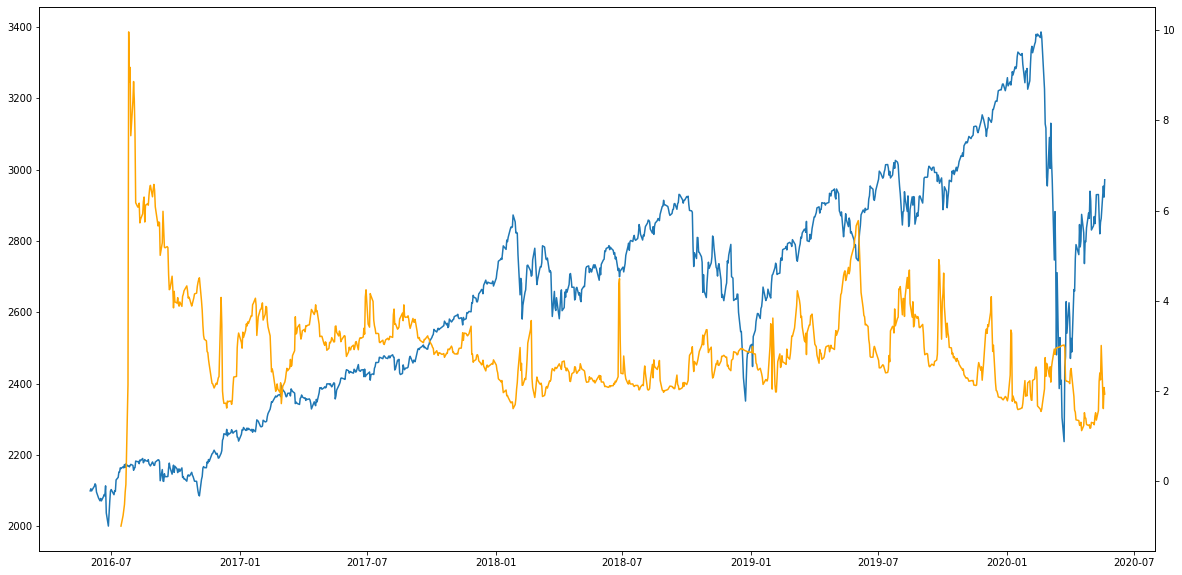

In [7]:
fig,ax = plt.subplots(figsize=(20, 10))
ax.plot(df.index, df['S&P 500'])
ax2=ax.twinx()
ax2.plot(sr.index, sr, color='orange')
plt.show()